Automatically created module for IPython interactive environment
Storage type.....: 1.2.840.10008.5.1.4.1.1.4

Patient's name...: Fall 1, 
Patient id.......: 11788759296811
Modality.........: MR
Study Date.......: 20010101
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.732421875, 0.732421875]
Slice location...: 67.9999789003008


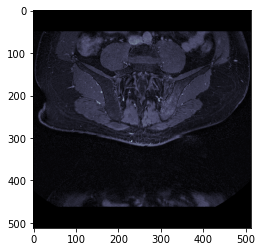

In [69]:
import matplotlib.pyplot as plt
import pydicom


print(__doc__)

dataset = pydicom.dcmread('democases/case1/case1_068.dcm')

# Normal mode:
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

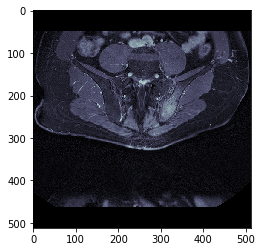

In [49]:

pictures = []
def dicom_list_picutre():
    dataset = pydicom.dcmread('democases/case1/case1_062.dcm')
    

    # Normal mode:
    print()
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Patient id.......:", dataset.PatientID)
    print("Modality.........:", dataset.Modality)
    print("Study Date.......:", dataset.StudyDate)

    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

    # use .get() if not sure the item exists, and want a default value if missing
    print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

In [51]:
%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [65]:
data_path = "democases/case1"
output_path = working_path = "/output/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 31 DICOM images.
First 5 filenames:
democases/case1\case1_008.dcm
democases/case1\case1_010.dcm
democases/case1\case1_012.dcm
democases/case1\case1_014.dcm
democases/case1\case1_016.dcm


In [68]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(data_path):
    slices = [pydicom.read_file(data_path + '/' + s) for s in os.listdir(data_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

PermissionError: [Errno 13] Permission denied: 'democases/case1/.ipynb_checkpoints'

In [54]:
np.save(data_path + "case1_%d.npy" % (id), imgs)

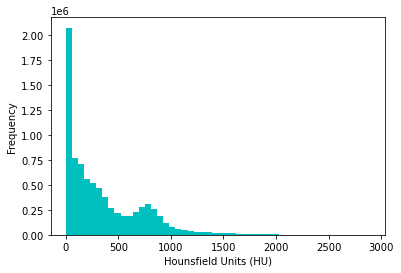

In [55]:
file_used=data_path+"case1_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

IndexError: index 31 is out of bounds for axis 0 with size 31

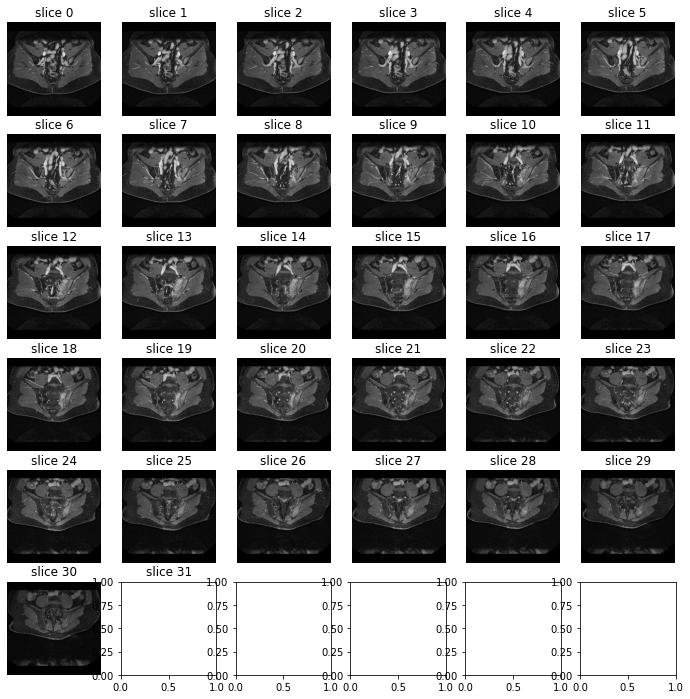

In [61]:
id = 0
imgs_to_process = np.load(data_path+'case1_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)